### Train a cats vs dogs classifier

In [1]:
import os
import cv2
import time
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DIR_TRAIN = "./train_cats_dogs/"

In [3]:
imgs = os.listdir(DIR_TRAIN) 

print(imgs[:5])

['dog.1564.jpg', 'dog.5155.jpg', 'dog.5943.jpg', 'dog.6978.jpg', 'dog.3523.jpg']


In [4]:
print(f"Number of images: {len(imgs)}")

Number of images: 25000


In [5]:
# mappa la classe ad un intero
class_to_int = {
    "cat" : 0,
    "dog" : 1
}

In [6]:
# augmentation only on train set
def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])
    
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [7]:
class CatDogDataset(Dataset):
    
    def __init__(self, imgs, class_to_int, mode = "train", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        
        ### Reading, converting and normalizing image
        #img = cv2.imread(DIR_TRAIN + image_name, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (224,224))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img /= 255.
        img = Image.open(DIR_TRAIN + image_name)
        img = img.resize((224, 224))
        
        if self.mode == "train" or self.mode == "val":
        
            ### Preparing class label
            label = self.class_to_int[image_name.split(".")[0]]
            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label
        
        elif self.mode == "test":
            
            ### Apply Transforms on image
            img = self.transforms(img)

            return img
            
        
    def __len__(self):
        return len(self.imgs)

In [8]:
train_imgs, val_imgs = train_test_split(imgs, test_size = 0.20)

In [9]:
train_dataset = CatDogDataset(train_imgs, class_to_int, mode = "train", transforms = get_train_transform())
val_dataset = CatDogDataset(val_imgs, class_to_int, mode = "val", transforms = get_val_transform())

# batch_size was 16
BATCH_SIZE = 32

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 4,
    batch_size = BATCH_SIZE,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 4,
    batch_size = BATCH_SIZE,
    shuffle = True
)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
def accuracy(preds, trues):
    THR = 0.5
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= THR else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)

In [12]:
def train_one_epoch(train_data_loader):
    
    model.train()
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ### Iterating over data loader
    for images, labels in tqdm(train_data_loader):
        
        # Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        # Reseting Gradients
        optimizer.zero_grad()
        
        # Forward
        preds = model(images)
        
        # Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        # Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        # Backward
        _loss.backward()
        optimizer.step()
    
    ### Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ### Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    # TODO: improve this one
    epoch_acc = np.mean(epoch_acc)
    
    ### Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time

In [13]:
def val_one_epoch(val_data_loader, best_val_acc):
    
    model.eval()
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ### Iterating over data loader
    for images, labels in val_data_loader:
        
        # Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        # Forward
        preds = model(images)
        
        # Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        # Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ### Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ### Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ### Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ### Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc

In [23]:
# This way no layer is frozen

model = resnet50(pretrained = True)

# Modifying Head, adding final classifier

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

In [24]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00008)

# Learning Rate Scheduler
# (LS): check, I don't think it is used
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
EPOCHS = 10

In [25]:
best_val_acc = 0

for epoch in range(EPOCHS):
    
    ### Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    # Print Epoch Details
    print()
    print(f"Training: Epoch {epoch}, Loss : {round(loss, 4)} Acc : {round(acc, 4)}, Time : {round(_time, 4)}")
    
    ### Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    # Print Epoch Details
    print()
    print(f"Validation: Epoch {epoch}, Loss : {round(loss, 4)} Acc : {round(acc, 4)}, Time : {round(_time, 4)}")

100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


Training: Epoch 0, Loss : 0.0598 Acc : 97.805, Time : 98.1429



Validation: Epoch 0, Loss : 0.0303 Acc : 98.8455, Time : 10.3153


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


Training: Epoch 1, Loss : 0.0353 Acc : 98.67, Time : 98.159



Validation: Epoch 1, Loss : 0.0388 Acc : 98.4674, Time : 10.3223


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


Training: Epoch 2, Loss : 0.0279 Acc : 99.045, Time : 98.1575



Validation: Epoch 2, Loss : 0.0591 Acc : 97.8304, Time : 10.384


100%|██████████| 625/625 [01:38<00:00,  6.36it/s]


Training: Epoch 3, Loss : 0.0262 Acc : 99.065, Time : 98.3133



Validation: Epoch 3, Loss : 0.0308 Acc : 98.7659, Time : 10.4232


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


Training: Epoch 4, Loss : 0.019 Acc : 99.325, Time : 98.1852



Validation: Epoch 4, Loss : 0.0429 Acc : 98.5669, Time : 10.3937


100%|██████████| 625/625 [01:38<00:00,  6.36it/s]


Training: Epoch 5, Loss : 0.0208 Acc : 99.3, Time : 98.2028



Validation: Epoch 5, Loss : 0.0266 Acc : 98.9451, Time : 10.362


100%|██████████| 625/625 [01:38<00:00,  6.37it/s]


Training: Epoch 6, Loss : 0.0187 Acc : 99.34, Time : 98.1987



Validation: Epoch 6, Loss : 0.0249 Acc : 99.0446, Time : 10.3469


100%|██████████| 625/625 [01:38<00:00,  6.36it/s]


Training: Epoch 7, Loss : 0.0177 Acc : 99.41, Time : 98.2214



Validation: Epoch 7, Loss : 0.0451 Acc : 98.5868, Time : 10.3183


100%|██████████| 625/625 [01:38<00:00,  6.36it/s]


Training: Epoch 8, Loss : 0.0153 Acc : 99.465, Time : 98.225



Validation: Epoch 8, Loss : 0.0517 Acc : 98.2285, Time : 10.3597


100%|██████████| 625/625 [01:38<00:00,  6.36it/s]


Training: Epoch 9, Loss : 0.0169 Acc : 99.39, Time : 98.2283



Validation: Epoch 9, Loss : 0.0365 Acc : 98.6863, Time : 10.5236


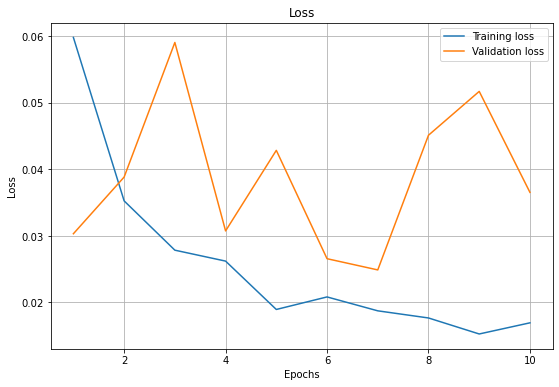

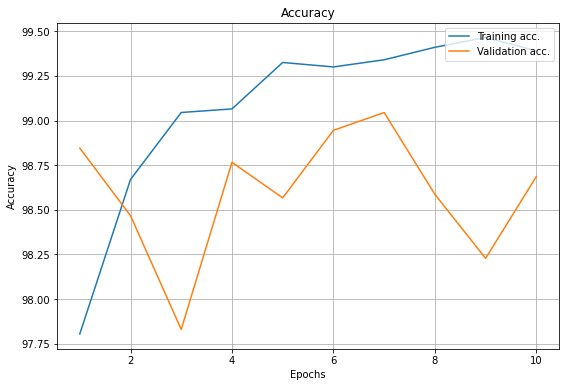

In [26]:
### Plotting Results

vet_epochs = np.arange(1, 11, 1)

# Loss
plt.figure(figsize=(9, 6))
plt.title("Loss")
plt.plot(vet_epochs, train_logs["loss"], label='Training loss')
plt.plot(vet_epochs, val_logs["loss"], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(9, 6))
plt.title("Accuracy")
plt.plot(vet_epochs, train_logs["accuracy"], label='Training acc.')
plt.plot(vet_epochs, val_logs["accuracy"], label='Validation acc.')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()